# TO DO

### POST SEASON PLAY-IN AGG DATA NOT INCLUDED FOR TEAMS THAT DID NOT GO TO PLAYOFFS, NANs BREAKING MODEL
## Why does regular but not post have the following: ['sos', 'OPPO_srs', 'OPPO_mov', 'OPPO_sos', 'OPPO_attend_g', 'srs', 'attend_g', 'mov']

0) Add more evaluations
1) Research how to make dimensionality reduction work and still be able to get a prediction
2) Move desired current prediction to the top of the sheet
3) Verify the results are being interpreted correctly
4) Was the CSV more recent games? The csv sheet has a higher % accuracy
5) The difference between the basic model and the auto model is... interesting

### Current Parameters:

In [1]:
use_post_season = "yes" # "yes" means yes, all else is no

# Number of Neurons
neurons_1 = 27
neurons_2 = 15
neurons_3 = 12
neurons_4 = 3

# Activation Types
activation_1 = "relu" # Original: "relu"
activation_2 = "sigmoid"
activation_3 = "sigmoid"
activation_4 = "sigmoid"
activation_outer = "sigmoid"

# Number of Epochs
num_epochs = 20 # Original: 50

### Import Dependencies

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sqlalchemy import create_engine
import pandas as pd
import tensorflow as tf
import keras
import os
import pandas as pd

# Preprocessing

### Extracting from the Database

In [3]:
rds_connection_string = f"postgres:postgres@localhost:5432/group_2_project_4"
engine = create_engine(f"postgresql://{rds_connection_string}")

nba_df = pd.read_sql_query('select * from reg_season_matches', con=engine)
nba_post = pd.read_sql_query('select * from post_season_matches', con=engine)
reg_season_compiled = pd.read_sql_query('select * from reg_season_stats', con=engine)
post_season_compiled = pd.read_sql_query('select * from post_season_stats', con=engine)

name_abbv = pd.read_sql_query('select * from teams', con=engine)

In [4]:
# post_season_compiled
# reg_season_compiled 
# nba_df
# nba_post
# name_abbv

### Combine DataFrames

In [52]:
# Create "matches" for the usuable match up data
matches = nba_df[["team", "w_l", "type", "opponent"]].copy()
matches = matches.dropna()

# Merge Agg Data with Abbv to create a dataframe with the aggregate data and the team abbreviation
reg_season_abbv = reg_season_compiled.merge(name_abbv, how = "left", left_on = "team", right_on = "team_name")

# Drop the full team names in favor of the abbv
reg_season_abbv = reg_season_abbv.drop(["team", "team_name"], axis = 1)

# Distinguish Opponent Data from "Defending" Team Data
oppo_reg_season_abbv = reg_season_abbv.add_prefix('OPPO_')

# Merge Team Agg Info with Match Info, twice... Once for defending team, once for opponent
team_games_data = matches.merge(reg_season_abbv, how = "left", left_on = "team", right_on = "abbreviation").merge(oppo_reg_season_abbv, how = "left", left_on = "opponent", right_on = "OPPO_abbreviation")

# Drop target and superfluous columns
team_games_data = team_games_data.drop(["abbreviation", "OPPO_abbreviation"], axis = 1)

# Adding in post-season data:
if use_post_season == "yes":
    
    # Create "post_matches" for the usuable post season match up data
    post_matches = nba_post[["team", "w_l", "type", "opponent"]].copy()
    post_matches = post_matches.dropna()
    
    # Merge Agg Data with Abbv to create a dataframe with the aggregate data and the team abbreviation
    post_season_abbv = post_season_compiled.merge(name_abbv, how = "left", left_on = "team", right_on = "team_name")
    
    # Drop the full team names in favor of the abbv
    post_season_abbv = post_season_abbv.drop(["team", "team_name"], axis = 1)
       
    # Distinguish Opponent Data from "Defending" Team Data
    oppo_post_season_abbv = post_season_abbv.add_prefix('OPPO_')
    
    # Merge Team Agg Info with Match Info, twice... Once for defending team, once for opponent
    post_games_data = post_matches.merge(post_season_abbv, how = "left", left_on = "team", right_on = "abbreviation").merge(oppo_post_season_abbv, how = "left", left_on = "opponent", right_on = "OPPO_abbreviation")
    
    # Drop target and superfluous columns
    post_games_data = post_games_data.drop(["abbreviation", "OPPO_abbreviation"], axis = 1)

    # This is effectively dropping play-in matches until/unless we have play-in stats
    post_games_data = post_games_data.dropna()
    
    # These columns are getting dropped until/unless placeholders can be calculated for items the regular season has that play-off do not
    team_games_data = team_games_data.drop(['sos', 'OPPO_srs', 'OPPO_mov', 'OPPO_sos', 'OPPO_attend_g', 'srs', 'attend_g', 'mov'], axis = 1)
    
    # Make the column orders match
    columns = list(team_games_data.columns)
    post_games_data = post_games_data[columns].copy()
    
    # Concat post season games date and regular season games data
    team_games_data = pd.concat([post_games_data, team_games_data], ignore_index=True)


In [15]:
# Run this cell to check dtypes

# for i in range(0, len(reg_season_abbv.columns)):
#     print(f"{reg_season_abbv.columns[i]}: {reg_season_abbv.dtypes[i]}")

In [53]:
# Confirm a lack of differences
print(list(set(team_games_data.columns) - set(post_games_data.columns))) # Regular Season has these, Post Season doesn't
print(list(set(post_games_data.columns) - set(team_games_data.columns)))

[]
[]


# Dummies, Scaling, Splitting Data

I wasn't able to filter y out the same way as the homework, but this seems to work.  Note: I tried the hw method before dropping W/L above this line

In [17]:
# Designate the target values as the winning side of w_l
target = team_games_data["w_l"]

y = pd.get_dummies(target)
y = y["W"]
y.shape

(2630,)

In [18]:
# Designate Features and convert categorical data to numeric with `pd.get_dummies`
features = team_games_data.drop(["w_l"], axis = 1)

X = pd.get_dummies(features)
X.shape

(2630, 188)

In [19]:
# Run this cell to check dtypes

# for i in range(0, len(X.columns)):
#     print(f"{X.columns[i]}: {X.dtypes[i]}")

In [20]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [21]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Compile, Train, and Evaluate the Neural Network Models

In [22]:
# Find Best Model from previous runs - This code finds the first model with the highest accuracy in the list, not all models with the same (shared) highest accuracy

def get_best_saved_model():

    if use_post_season == "yes":
        current_folder = "Post_Season"
    else:
        current_folder = "Reg_Season"

    folder_list = os.listdir(f'Models/{current_folder}')       
    model_list = []
    accu_list = []  
    
    # Compile a list of models
    for file in folder_list:
        first_word = file.split("_")[0]
        if first_word == "NBA":
            model_list.append(file)

    # Exract the accuracy of the models
    for model in model_list:
        model_name = model.split(".")[0]
        model_accu = model_name[-4:]
        accu_list.append(model_accu)

    # Find the index of the best accuracy
    best_saved_accuracy = max(accu_list)
    index = accu_list.index(best_saved_accuracy)
    
    # Get the name of the best saved model
    best_saved_model = model_list[index]
        
    return int(best_saved_accuracy), best_saved_model, current_folder

In [23]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_features = len(X_train_scaled[0])

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = neurons_1, activation = activation_1, input_dim = num_features))

# Second hidden layer ("If Necessary")
nn.add(tf.keras.layers.Dense(units = neurons_2, activation = activation_2))

# Third hidden layer ("If Necessary")
nn.add(tf.keras.layers.Dense(units = neurons_3, activation = activation_3))

# Third hidden layer ("If Necessary")
nn.add(tf.keras.layers.Dense(units = neurons_4, activation = activation_4))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation = activation_outer))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 27)                5103      
_________________________________________________________________
dense_1 (Dense)              (None, 15)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                192       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 39        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 4         
Total params: 5,758
Trainable params: 5,758
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=num_epochs)

Epoch 1/20
62/62 [==============================] - 0s 490us/step - loss: 0.7628 - accuracy: 0.4959
Epoch 2/20
62/62 [==============================] - 0s 426us/step - loss: 0.7159 - accuracy: 0.4959
Epoch 3/20
62/62 [==============================] - 0s 434us/step - loss: 0.6972 - accuracy: 0.4959
Epoch 4/20
62/62 [==============================] - 0s 434us/step - loss: 0.6847 - accuracy: 0.4959
Epoch 5/20
62/62 [==============================] - 0s 434us/step - loss: 0.6746 - accuracy: 0.4959
Epoch 6/20
62/62 [==============================] - 0s 434us/step - loss: 0.6659 - accuracy: 0.5401
Epoch 7/20
62/62 [==============================] - 0s 483us/step - loss: 0.6583 - accuracy: 0.6623
Epoch 8/20
62/62 [==============================] - 0s 515us/step - loss: 0.6510 - accuracy: 0.6714
Epoch 9/20
62/62 [==============================] - 0s 466us/step - loss: 0.6441 - accuracy: 0.6770
Epoch 10/20
62/62 [==============================] - 0s 434us/step - loss: 0.6372 - accuracy: 0.6831

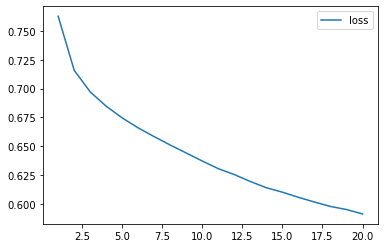

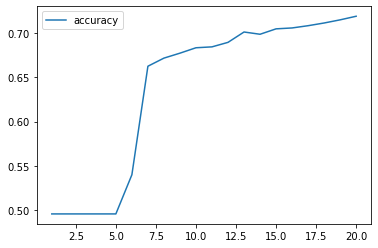

In [26]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
history_df.plot(y="accuracy");

In [27]:
# Evaluate the model using the test data
current_model_loss, current_model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Loss: {current_model_loss}, Accuracy: {current_model_accuracy}")

Loss: 0.6594522595405579, Accuracy: 0.6231002807617188


In [59]:
# Define best_saved_accuracy so that only models with better accuracy are saved
best_saved_accuracy, best_saved_model, current_folder = get_best_saved_model()
accu = round(current_model_accuracy * 10_000)
model_source = "basic"

# Save and export results to an HDF5 file
if accu > best_saved_accuracy:
    accu_formatted = "{:.2%}".format(accu / 10_000)
    nn.save(f"Models/{current_folder}/NBA_model_{model_source}{accu}.h5")
    print(f"Model saved with {accu_formatted} accuracy in {current_folder}")

# GAME PREDICTION

In [31]:
# Boston Celtics BOS @ Golden State Warriors GSW

# Test predictions on PHX vs. HOU

team_A = "GSW" #TEAM
game_type = "@" #TYPE
team_B = "BOS" #OPPONENT

d = {"team": team_A, "type": game_type, "opponent": team_B}

current_match = pd.DataFrame(data = d, index=[0])
current_match

,team,type,opponent
0,GSW,@,BOS


### Create dataframe that matches the columns from "X_train"

In [34]:
# Merge aggregate info into the match data frame

if use_post_season == "yes":
    current_game_data = current_match.merge(post_season_abbv, how = "left", left_on = "team", right_on = "abbreviation").merge(oppo_post_season_abbv, how = "left", left_on = "opponent", right_on = "OPPO_abbreviation")
    current_game_data = pd.get_dummies(current_game_data.drop(["abbreviation", "OPPO_abbreviation"], axis = 1))
else:
    current_game_data = current_match.merge(reg_season_abbv, how = "left", left_on = "team", right_on = "abbreviation").merge(oppo_reg_season_abbv, how = "left", left_on = "opponent", right_on = "OPPO_abbreviation")
    current_game_data = pd.get_dummies(current_game_data.drop(["abbreviation", "OPPO_abbreviation"], axis = 1))

# Add missing columns and assign a value of "0" for each
fill_list = list(set(X.columns) - set(current_game_data.columns))

for i in fill_list:
    current_game_data[i] = 0

# Make the column orders match
columns = list(X_train.columns)
current_game_data = current_game_data[columns].copy()

In [36]:
# Confirm a lack of differences
print(list(set(current_game_data.columns) - set(X_train.columns)))
print(list(set(X_train.columns) - set(current_game_data.columns)))

# Confirm columns are in the same order
# for i in range(0, len(X_train.columns - 1)):
#     if current_game_data.columns[i] != X_train.columns[i]:
#         print(f"column {i} does not match")

[]
[]


In [37]:
# Use dataframe of current match data to generate prediction - https://machinelearningmastery.com/make-predictions-scikit-learn/
X_new = X_scaler.transform(current_game_data)
y_new = nn.predict([X_new])

win_chance = "{:.2%}".format(y_new[0][0])
model_accuracy_perc = "{:.2%}".format(current_model_accuracy)
print(f"{team_A} has a {win_chance} chance to win {game_type} {team_B} according to the current model ({model_accuracy_perc} accuracy).")

GSW has a 61.88% chance to win @ BOS according to the current model (62.31% accuracy).


## Compare to Best Saved Model

In [38]:
# Load the model
saved_model = load_model(f"Models/{current_folder}/{best_saved_model}")

# Evaluate the model using the test data
saved_model_loss, saved_model_accuracy = saved_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Loss: {saved_model_loss}, Accuracy: {saved_model_accuracy}")

Loss: 0.6594522595405579, Accuracy: 0.6231002807617188


In [39]:
y_new = saved_model.predict([X_new])

win_chance = "{:.2%}".format(y_new[0][0])
model_accuracy_perc = "{:.2%}".format(saved_model_accuracy)

print(f"{team_A} has a {win_chance} chance to win {game_type} {team_B} according to the best saved model ({model_accuracy_perc} accuracy).")

GSW has a 61.88% chance to win @ BOS according to the best saved model (62.31% accuracy).


# Automated Optimization
The auto-optimizer will not create new models unless "untitled_project" is deleted first

In [40]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=2), activation=activation, input_dim=num_features))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [41]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=50,
    hyperband_iterations=2)

In [42]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled, y_train, epochs = 20, validation_data=(X_test_scaled,y_test))

Trial 180 Complete [00h 00m 03s]
val_accuracy: 0.6322188377380371

Best val_accuracy So Far: 0.6747720241546631
Total elapsed time: 00h 03m 26s
INFO:tensorflow:Oracle triggered exit


In [43]:
X_train_scaled.shape, X_test_scaled.shape

((1972, 188), (658, 188))

In [44]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters()[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 17,
 'num_layers': 1,
 'units_0': 13,
 'units_1': 3,
 'units_2': 3,
 'units_3': 17,
 'units_4': 29,
 'units_5': 1,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [45]:
def get_best_model(nn, parameters, X_train_scaled, y_train):
    clf = GridSearchCV(model, parameters, cv=4, n_jobs=-1)
    clf.fit(X_train, y_train)
    # print(clf.best_params_)
    return clf.best_estimator_ 

In [46]:
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

In [47]:
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# param_grid = dict(activation=activation)


# param_grid = dict(epochs=[10, 20, 30])
# grid = GridSearchCV(estimator=model, param_grid = param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X_train, y_train)

In [48]:
# best_model = tuner.get_best_models()[0]
# best_model

The following cell will start to break if you run it too many times before restarting the kernal

In [49]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
auto_model_loss, auto_model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {auto_model_loss}, Accuracy: {auto_model_accuracy}")

21/21 - 0s - loss: 0.6330 - accuracy: 0.6748
Loss: 0.6329891681671143, Accuracy: 0.6747720241546631


In [60]:
# Define best_saved_accuracy so that only models with better accuracy are saved
best_saved_accuracy, best_saved_model, current_folder = get_best_saved_model()
accu = round(auto_model_accuracy * 10_000)
model_source = "auto"

# Save and export results to an HDF5 file
if accu > best_saved_accuracy:
    accu_formatted = "{:.2%}".format(accu / 10_000)
    nn.save(f"Models/{current_folder}/NBA_model_{model_source}{accu}.h5")
    print(f"Model saved with {accu_formatted} accuracy in {current_folder}")

## Auto-Optimizer Prediction

In [51]:
y_auto_model = best_model.predict([X_new])

win_chance = "{:.2%}".format(y_auto_model[0][0])
model_accuracy_perc = "{:.2%}".format(auto_model_accuracy)

print(f"{team_A} has a {win_chance} chance to win {game_type} {team_B} according to the best auto-optimized model ({model_accuracy_perc} accuracy).")

GSW has a 39.49% chance to win @ BOS according to the best auto-optimized model (67.48% accuracy).


# RandomForestsClassifier

In [99]:
rfc = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)

In [100]:
print(f'Training Score: {rfc.score(X_train_scaled, y_train)}')
print(f'Testing Score: {rfc.score(X_test_scaled, y_test)}')

Training Score: 0.8563685636856369
Testing Score: 0.6032520325203252


In [102]:
flatten=[]
for x in range(X_new[0].size):
    flatten.append(X_new[0][x])
#print(test)
y_rfc = rfc.predict([flatten])
y_rfc

array([0], dtype=uint8)

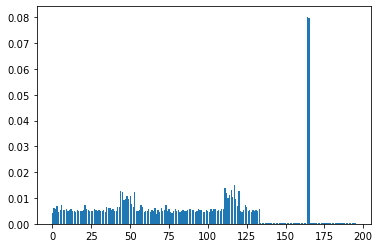

In [103]:
features = rfc.feature_importances_
# print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

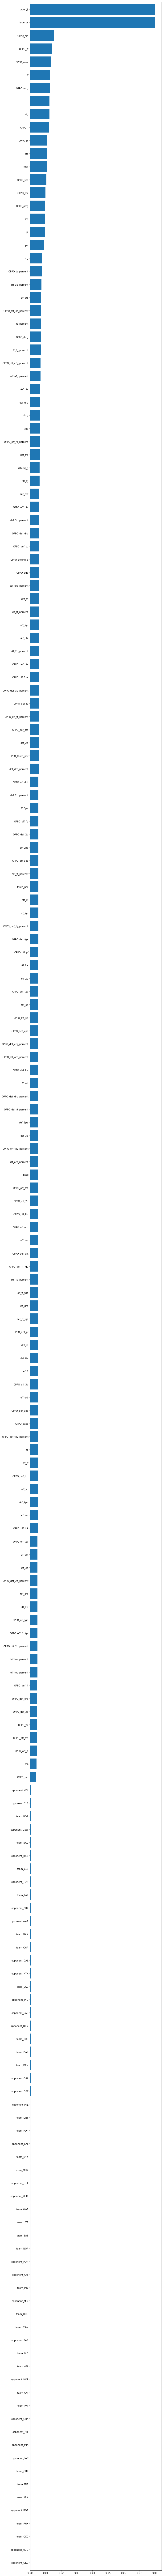

In [104]:
features = sorted(zip(X.columns, rfc.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,200)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [105]:
# Attempt Feature Selection

from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(rfc)
sel.fit(X_train_scaled, y_train)
sel.get_support()

array([False,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True, False, False, False,  True, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False, False,  True, False,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True, False, False, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True,  True, False,  True, False, False, False,  True, False,
        True, False, False,  True, False, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True, False, False,
        True,  True, False,  True, False,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,

In [106]:
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)

scaler = StandardScaler().fit(X_selected_train)

X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

C:\Users\emera\anaconda3\envs\tf2\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [107]:
clf = LogisticRegression()
clf.fit(X_selected_train_scaled, y_train)
print(f'Training Score: {clf.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_selected_test_scaled, y_test)}')

Training Score: 0.6601626016260163
Testing Score: 0.6634146341463415


C:\Users\emera\anaconda3\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [108]:
test=[]
for x in range(X_new[0].size):
    test.append(X_new[0][x])
#print(test)
y_rfc = rfc.predict([test])
y_rfc

array([0], dtype=uint8)

In [109]:
y_rfc = rfc.predict([X_new])
y_rfc

ValueError: Found array with dim 3. Estimator expected <= 2.

# OLD HOMEWORK STARTS HERE

In [ ]:
# Create a callback that saves the model's weights every 5 epochs.
saves = 5
mc = keras.callbacks.ModelCheckpoint('Optimized_Weights/weights{epoch:08d}.h5', save_weights_only=True, save_freq=saves, verbose = 0)

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=num_epochs, callbacks=[mc])